In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYSR_AUTOLOAD_EXTENSIONS'] = 'no'
from matplotlib import pyplot as plt
from utils import load_pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
%matplotlib inline
plt.rcParams["font.family"] = "serif"

In [3]:
from interpret import *

/home/sca63/.conda/envs/new_bnn/lib/python3.7/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  "torch was imported before juliacall. This may cause a segfault. "


In [4]:
version = 24880
pysr_version = 11003

In [5]:
feature_nn = get_feature_nn(version)
results = get_pysr_results(pysr_version, version=version, include_ssx=False, feature_nn=feature_nn)
important_complexities = None

In [6]:
test_results = load_pickle(f'pickles/pysr_results_all_{version}_{pysr_version}.pkl')
complexity, val_error, test_error, random_error = best_result(test_results)
print('Equation complexity with best error on validation set:', complexity)
print(f'Error for best equation on resonant test set: {test_error:.3f}, random: {random_error:.3f}')

c26, val: 1.34, test: 1.34, random: 1.42
Equation complexity with best error on validation set: 26
Error for best equation on resonant test set: 1.342, random: 1.419


In [8]:
f1_str_0 = feature_string(feature_nn, 0, include_ssx=True, include_ssx_bias=True, latex=True)
print(f1_str_0)

14.0  e_1 - 35.0  e_2 + 0.911


In [ ]:
def feature_plot_title(feature_nn, i, std=False):
    feature_str = feature_string(feature_nn, i, include_ssx=True, include_ssx_bias=True, latex=True)
    if std:
        return f"Feature {i} std: $\\text{{Std}}[{feature_str}]$"
    else:
        return f"Feature {i} mean: $\\mathbb{{E}}[{feature_str}]$"

SyntaxError: unexpected EOF while parsing (2764215031.py, line 1)

In [8]:
f1_str = f1_latex_string(feature_nn, include_ssx=True, include_ssx_bias=True, pysr_results=results)
print(f1_str)

\begin{align*}
    &0^*: 14.0  e_1 - 35.0  e_2 + 0.911 \\ 
    &1: 210  a_1 + 85400  m_1 - 211 \\ 
    &2: 27000  m_1 - 4.02  a_3 + 6.01 \\ 
    &3^*: 0.764  \sin\Omega_3 - 1.10  \sin\Omega_2 + 0.00289 \\ 
    &4: 14.0  a_3 - 27.5  a_2 + 12.5 \\ 
    &5^*: 29.1  e_3 + 1.47  e_1 - 1.34 \\ 
    &6: 13.1  i_3 + 37.5  i_2 - 1.38 \\ 
    &7: 58400  m_2 - 4.92  e_3 - 0.725 \\ 
    &8: 21.1  e_1 - 4.48  e_3 - 0.948 \\ 
    &9^*: 0.957  e_1 + 64600  m_3 - 0.839 \\ 
\end{align*}


In [9]:
f2_str = f2_latex_str(results, mapping_dict=None)
print(f2_str)

\begin{table}[h]
\begin{center}
\begin{tabular}{@{}ccc@{}}
\toprule
Equation & Complexity & RMSE \\
\midrule
$\log_{10} T_{\text{inst}} = 7.0$ & $1$ & $1.66$ \\
$\log_{10} T_{\text{inst}} = 7.0 - \mu_{2}$ & $3$ & $1.66$ \\
$\log_{10} T_{\text{inst}} = 7.2 - \sin{\left(\mu_{2} \right)}$ & $4$ & $1.62$ \\
$\log_{10} T_{\text{inst}} = \frac{3.6}{\sigma_{4}^{0.15}}$ & $5$ & $1.62$ \\
$\log_{10} T_{\text{inst}} = - \mu_{2} + \frac{3.6}{\sigma_{4}^{0.16}}$ & $7$ & $1.52$ \\
$\log_{10} T_{\text{inst}} = - \mu_{2} + \left(\sigma_{1} \sigma_{4}\right)^{-0.16} + 3.6$ & $9$ & $1.53$ \\
\begin{minipage}{0.8\linewidth} \vspace{-1em} \begin{dmath*} \log_{10} T_{\text{inst}} = 0.14^{\sigma_{1}} \left(- \mu_{2} + \sigma_{4}^{-0.31}\right) + 3.7 \end{dmath*} \end{minipage} & $11$ & $1.45$ \\
\begin{minipage}{0.8\linewidth} \vspace{-1em} \begin{dmath*} \log_{10} T_{\text{inst}} = 0.16^{\sigma_{1}} \left(- \mu_{2} + \sigma_{4}^{-0.32} - \sigma_{6}\right) + 3.7 \end{dmath*} \end{minipage} & $13$ & $1.44$ 

In [10]:
nn_results = load_pickle(f'pickles/nn_results_all_12318.pkl')
petit_results = load_pickle('pickles/petit_results_all.pkl')
pure_sr_results = load_pickle('pickles/pure_sr_results_all_83941.pkl')
direct_sr_results = load_pickle('pickles/pysr_results_all_28114_9054.pkl')
pysr_results = load_pickle(f'pickles/pysr_results_all_{version}_{pysr_version}.pkl')

In [11]:
pysr_c, _ = min(pysr_results['val'].items(), key=lambda e: e[1])
pure_c, _ = min(pure_sr_results['val'].items(), key=lambda e: e[1])
direct_c, _ = min(direct_sr_results['val'].items(), key=lambda e: e[1])

In [12]:
# table for paper
print(f'NN: resonant: {nn_results["test"]:.3f}, random {nn_results["random"]:.3f}')
print(f'Ours: resonant: {pysr_results["test"][pysr_c]:.3f}, random {pysr_results["random"][pysr_c]:.3f}')
print(f'Petit: resonant: {petit_results["test"]:.3f}, random {petit_results["random"]:.3f}')
print(f'Direct SR: resonant: {direct_sr_results["test"][direct_c]:.3f}, random {direct_sr_results["random"][direct_c]:.3f}')
print(f'Pure SR: resonant: {pure_sr_results["test"][pure_c]:.3f}, random {pure_sr_results["random"][pure_c]:.3f}')

NN: resonant: 0.961, random 1.059
Ours: resonant: 1.342, random 1.419
Petit: resonant: 3.129, random 3.004
Direct SR: resonant: 1.250, random 1.329
Pure SR: resonant: 1.360, random 1.397


In [13]:
important_complexities = results['complexity'].tolist()
important_complexities, _ = paretoize(important_complexities, results['rmse'].tolist(), replace=False)

In [14]:
%matplotlib inline

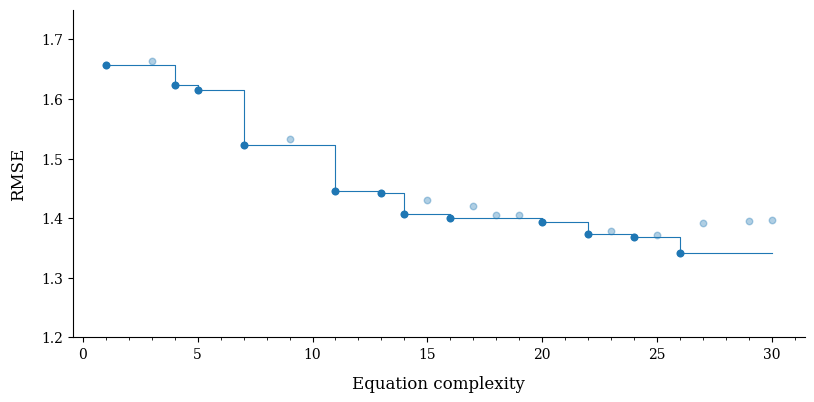

In [16]:
def make_pareto_plot(results, important_complexities):
    color = 'tab:blue'
    # plt.style.use('seaborn-darkgrid')
    plt.rcParams["font.family"] = "serif"
    scale = 0.75
    plt.figure(figsize=(11*scale, 5.5*scale))  # Width = 10 inches, Height = 6 inches
    ax = plt.gca()

    ax.scatter(results['complexity'], results['rmse'], s=22, color=color, alpha=0.35)

    ax.set_xlabel('Equation complexity', fontsize=12, labelpad=10)

    ax.set_ylabel('RMSE', fontsize=12, labelpad=10)

    important_ixs = get_important_ixs(results, important_complexities)
    important_ys = [results['rmse'][i] for i in important_ixs]
    ax.scatter(important_complexities, important_ys, s=22, color=color)

    ax.step(important_complexities + [results['complexity'].max()],
            important_ys + [important_ys[-1]],
            where='post',
            color=color,
            linewidth=0.8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='both', which='major', labelsize=10)
    # add minor tick marks
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    # Make minor ticks point outward
    ax.tick_params(axis="x", which="minor", direction="out")

    plt.ylim(1.2, 1.75)
    return plt

plot = make_pareto_plot(results, important_complexities=important_complexities)
plot.tight_layout()
# plot.show()
plot.savefig('graphics/pareto_fig1.svg')